# **Thông tin sinh viên**
Họ và tên: Mai Ngọc Trinh

MSSV     : 18021307

Link notion:  

# **1. Mô tả bài toán**
Mercari là một công ty thương mại điện tử hoạt động ở Nhật Bản và Mỹ, có các sản phẩm chính được giao dịch trên ứng dụng Mercari marketplace. 

Dưới đây là giao diện trang chủ của Mercari: https://www.mercari.com/

![](https://drive.google.com/uc?export=view&id=1qFk7NXFw5uurxGerS59jEO0eDewUlk2N)

Mọi người có thể mua bán các mặt hàng trên ứng dụng đó. Và vấn đề là làm sao có thể tìm được giá của mặt hàng giúp hài hoà giữa lợi ích của người bán và người mua. Giải pháp được đưa ra là ứng dụng sẽ phải đưa ra giá đề xuất của mặt hàng cho người muốn bán sản phẩm

Ví dụ: mô hình đưa ra đề xuất giá dựa vào những mô tả dưới đây

![](https://drive.google.com/uc?export=view&id=1skV0NNrE39ROOAX5-UNtz1Zy9nUVkhum)

Thử thách ở đây là xây dựng một mô hình có thể dự đoán giá phù hợp nhất cho các sản phẩm dựa trên các mô tả như trong ví dụ trên 

**Input:** thông tin mô tả về sản phẩm

**Output**: đề xuất giá bán phù hợp cho sản phẩm giúp người bán

# **2. Phân tích dữ liệu, convert và clean dữ liệu**

## 2.1 Import thư viện

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from wordcloud import WordCloud
from tqdm.notebook import tqdm
tqdm.pandas()
import regex as re
from nltk.stem import PorterStemmer
from nltk import word_tokenize
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

## 2.2 Tải và giải nén dữ liệu

In [2]:
!apt-get install p7zip
!p7zip -d -f -k /kaggle/input/mercari-price-suggestion-challenge/train.tsv.7z
!unzip -o /kaggle/input/mercari-price-suggestion-challenge/test_stg2.tsv.zip
!unzip -o /kaggle/input/mercari-price-suggestion-challenge/sample_submission_stg2.csv.zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  p7zip-full
The following NEW packages will be installed:
  p7zip
0 upgraded, 1 newly installed, 0 to remove and 18 not upgraded.
Need to get 358 kB of archives.
After this operation, 996 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 p7zip amd64 16.02+dfsg-6 [358 kB]
Fetched 358 kB in 1s (444 kB/s)
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package p7zip.
(Reading database ... 106894 files and directories currently installed.)
Preparing to unpack .../p7zip_16.02+dfsg-6_amd64.deb ...
Unpacking p7zip (16.02+dfsg-6) ...
Setting up p7zip (16.02+dfsg-6) ...

7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=C.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanni

## 2.3 Phân tích dữ liệu 

In [3]:
train_data = pd.read_csv('train.tsv', sep='\t')
test_data = pd.read_csv('test_stg2.tsv', sep='\t')

In [4]:
print(train_data.shape)
print(train_data.columns)

(1482535, 8)
Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description'],
      dtype='object')


In [5]:
train_data.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [6]:
test_data.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


File train (train.tsv) gồm 1482535 hàng và 8 cột:
- train_id: id của danh sách
- name: tiêu đề của sản phẩm
- item_condition_id: tình trạng của mặt hàng do người bán cung cấp, giá trị từ 1 (mới) đến 5 (cũ)
- category_name (tên danh mục): tên danh mục của sản phẩm
- brand_name: tên thương hiệu sản phẩm
- price: giá của mặt hàng, đơn vị là USD
- shipping: 1 nếu phí ship do người bán thanh toán, 0 là do người mua thanh toán
- item_description: miêu tả đầy đủ về mặt hàng

File test (test_stg2.tsv) gồm 3460725 hàng và 7 cột, không chứa cột test như file train

### 2.3.1 Kiểm tra giá trị null

In [7]:
train_data.isnull().sum(axis=0)

train_id                  0
name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

In [8]:
percent_null = train_data.isnull().sum() * 100 / len(train_data)
missing_value = pd.DataFrame({'Phần trăm giá trị null': percent_null})
print(missing_value)

                   Phần trăm giá trị null
train_id                         0.000000
name                             0.000000
item_condition_id                0.000000
category_name                    0.426769
brand_name                      42.675687
price                            0.000000
shipping                         0.000000
item_description                 0.000270


**Nhận xét**: giá trị null có ở 3 cột là brand_name, category_name và item_description. Cột brand_name chứa nhiều giá trị null nhất, còn hai cột còn lại chứa ít giá trị null 

### 2.3.2 Phân tích về cột price

Bài toán dự đoán giá sản phẩm nên cột price có vai trò quan trọng 

In [9]:
train_data['price'].describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

<AxesSubplot:xlabel='price', ylabel='Density'>

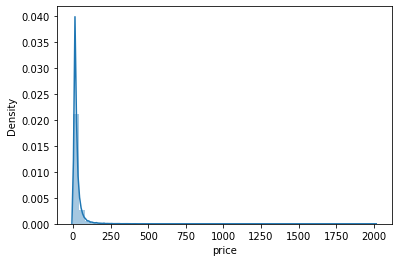

In [10]:
sns.distplot(train_data['price'], kde=True)

**Nhận xét**: Hầu hết các sản phẩm đều có giá trong khoảng từ 0 đến 250 USD. Có rất ít sản phẩm có giá cao hơn 250 USD

In [11]:
# Tỉ lệ phần trăm các mức giá
for i in range(0, 101, 10):
  print(i, 'th %: ', np.percentile(train_data['price'].values, i))

0 th %:  0.0
10 th %:  7.0
20 th %:  10.0
30 th %:  12.0
40 th %:  14.0
50 th %:  17.0
60 th %:  20.0
70 th %:  26.0
80 th %:  34.0
90 th %:  51.0
100 th %:  2009.0


In [12]:
for i in range(90, 101, 1):
  print(i, 'th %: ', np.percentile(train_data['price'].values, i))

90 th %:  51.0
91 th %:  55.0
92 th %:  58.0
93 th %:  62.0
94 th %:  67.0
95 th %:  75.0
96 th %:  85.0
97 th %:  99.0
98 th %:  122.0
99 th %:  170.0
100 th %:  2009.0


**Nhận xét**: 
- Có tới 99 % giá các sản phẩm nhỏ hơn 170 USD. Do đó có thể bỏ những sản phẩm có giá cao hơn khỏi tập train_data
- Phân phối giá nghiêng hẳn về phía trái. Ta sẽ áp dụng log transform trên cột price để đưa phân phối về dạng chuẩn

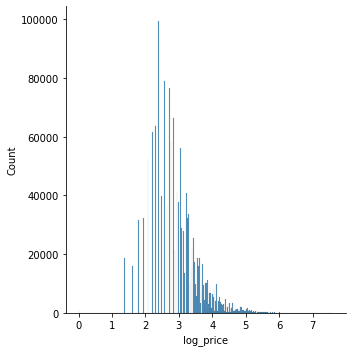

In [13]:
train_data['log_price'] = np.log1p(train_data['price'])
sns.displot(train_data['log_price'])

### 2.3.3 Phân tích cột shipping 

0    819435
1    663100
Name: shipping, dtype: int64
shipping 0:  55
shipping 1:  45


Text(0.5, 0, '0: phí ship do người mua thanh toán, 1: phí ship do người bán thanh toán ')

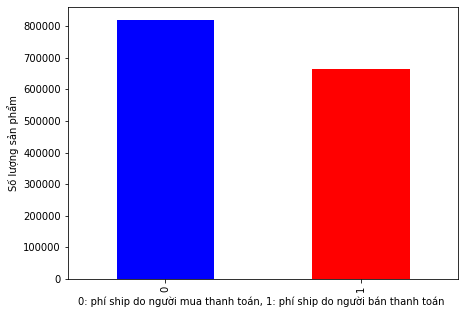

In [14]:
#tỉ lệ số mặt hàng có phí ship đựợc trả bởi người mua và người bán 
total_rows = train_data.shape[0]
total_shipping = train_data['shipping'].value_counts()
print(total_shipping)
shipping_0_percent = round((total_shipping[0] / total_rows) * 100)
shipping_1_percent = round((total_shipping[1] / total_rows) * 100)
print("shipping 0: ", shipping_0_percent)                   #0: phí ship do người mua thanh toán
print("shipping 1: ", shipping_1_percent)                   #1: phí ship do người bán thanh toán 

ax = train_data['shipping'].value_counts().plot.bar(color=['blue', 'red'], figsize=(7, 5))
ax.set_ylabel("Số lượng sản phẩm")
ax.set_xlabel("0: phí ship do người mua thanh toán, 1: phí ship do người bán thanh toán ")

**Nhận xét**: Số lượng mặt hàng mà người mua trả tiền ship nhiều hơn số lượng mặt hàng người bán trả tiền ship

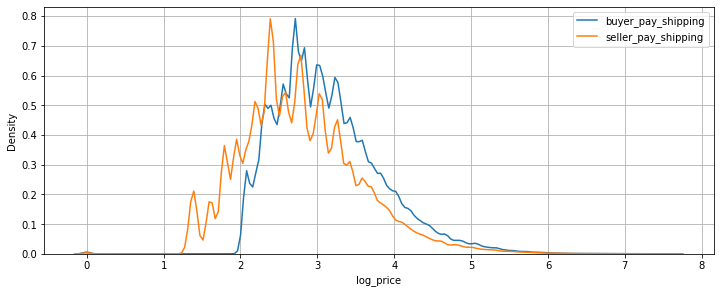

In [15]:
#log price 
buyer_pay_shipping = train_data[train_data['shipping'] == 0]['log_price']
seller_pay_shipping = train_data[train_data['shipping'] == 1]['log_price']
plt.figure(figsize=(12, 10))
plt.subplot(211)
ax = sns.distplot(buyer_pay_shipping, hist=False, label="buyer_pay_shipping")
ax = sns.distplot(seller_pay_shipping, hist=False, label="seller_pay_shipping")
h, l = ax.get_legend_handles_labels()
ax.legend(h, l)
plt.grid()

Nếu giá của sản phẩm nhỏ hơn 4 USD (antilog(1.8)) thì hầu như người bán trả hết phí ship

### 2.3.4 Phân tích cột item_condition_id
Cột có các giá trị từ 1 (mới) đến 5 (cũ)

item_condition_id 1:  43.206 %
item_condition_id 2:  25.327 %
item_condition_id 3:  29.15 %
item_condition_id 4:  2.156 %
item_condition_id 5:  0.161 %


<AxesSubplot:>

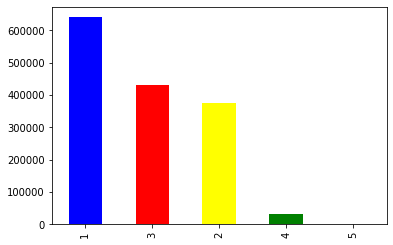

In [16]:
total_item_condition_id = train_data['item_condition_id'].value_counts()
print("item_condition_id 1: ", round((total_item_condition_id[1] / total_rows) * 100, 3), '%')
print("item_condition_id 2: ", round((total_item_condition_id[2] / total_rows) * 100, 3), '%')
print("item_condition_id 3: ", round((total_item_condition_id[3] / total_rows) * 100, 3), '%')
print("item_condition_id 4: ", round((total_item_condition_id[4] / total_rows) * 100, 3), '%')
print("item_condition_id 5: ", round((total_item_condition_id[5] / total_rows) * 100, 3), '%')
train_data['item_condition_id'].value_counts().plot.bar(color=['blue', 'red', 'yellow', 'green', 'pink'])

**Nhận xét**: Có sự chênh lệch lớn với số lượng mặt hàng, đặc biệt cột 4, 5 có số lượng rất ít. Điều này chứng tỏ các sản phẩm trong hệ thống đều còn mới hoặc không quá cũ

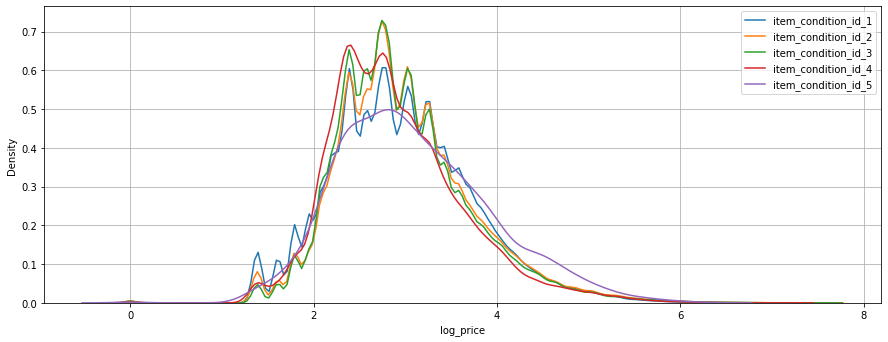

In [17]:
#log_price
item_condition_id_1 = train_data[train_data['item_condition_id'] == 1]['log_price']
item_condition_id_2 = train_data[train_data['item_condition_id'] == 2]['log_price']
item_condition_id_3 = train_data[train_data['item_condition_id'] == 3]['log_price']
item_condition_id_4 = train_data[train_data['item_condition_id'] == 4]['log_price']
item_condition_id_5 = train_data[train_data['item_condition_id'] == 5]['log_price']

plt.figure(figsize=(15,12))
plt.subplot(211)
ax = sns.distplot(item_condition_id_1, hist=False, label="item_condition_id_1")
ax = sns.distplot(item_condition_id_2, hist=False, label="item_condition_id_2")
ax = sns.distplot(item_condition_id_3, hist=False, label="item_condition_id_3")
ax = sns.distplot(item_condition_id_4, hist=False, label="item_condition_id_4")
ax = sns.distplot(item_condition_id_5, hist=False, label="item_condition_id_5")
h,l = ax.get_legend_handles_labels()
ax.legend(h, l)   #show color item_condition_id
plt.grid()

Giá từng mặt hàng trong cột log_price được trải khá giống phân phối chuẩn

### 2.3.5 Phân tích cột name

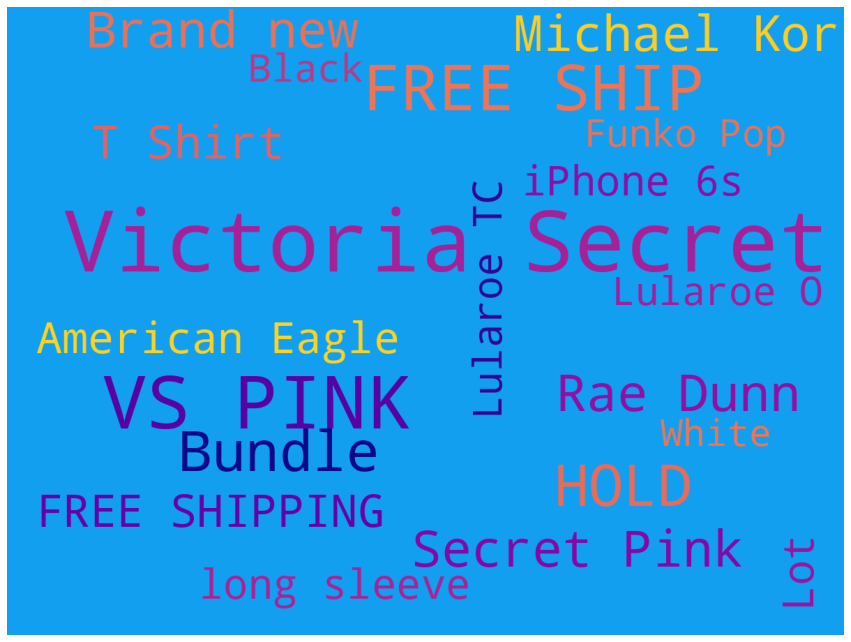

In [18]:
#đám mây từ khoá 
word_cloud = WordCloud(max_words=20, background_color="#139ff0", colormap="plasma",width = 1200, height = 900).generate(" ".join(train_data['name'].astype(str)))
plt.figure(figsize = (15, 14))
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

**Nhận xét**: có nhiều sản phẩm có name chứa tên thương hiệu (brand_name) và "free ship" để làm nổi bật thông tin với người mua.

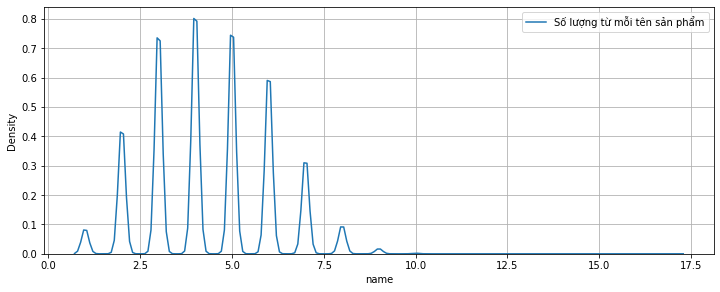

In [19]:
#số lượng từ mỗi tên sản phẩm
len_word = train_data['name'].str.split().str.len()
plt.figure(figsize=(12,10))
plt.subplot(211)
ax = sns.distplot(len_word, hist=False, label="Số lượng từ mỗi tên sản phẩm")
h,l = ax.get_legend_handles_labels()
ax.legend(h, l)
plt.grid()

Hầu hết các sản phẩm có độ dài tên từ 2 đến 7 từ 

### 2.3.6 Phân tích cột item_description

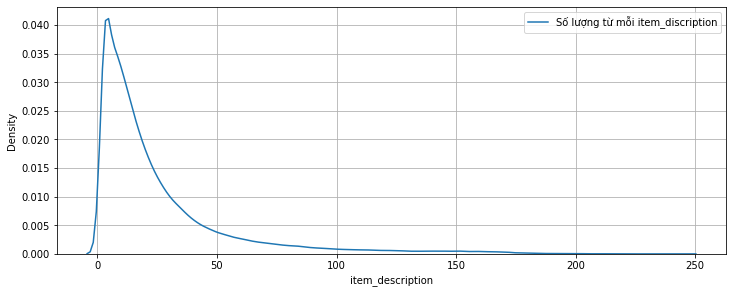

In [20]:
#Số lượng từ mỗi item_discription
word_counts = train_data['item_description'].str.split().str.len()
plt.figure(figsize=(12,10))
plt.subplot(211)
ax = sns.distplot(word_counts, hist=False, label="Số lượng từ mỗi item_discription")
h,l = ax.get_legend_handles_labels()
ax.legend(h, l)
plt.grid()

Cột item_description có số lượng từ mỗi sản phẩm là 0 đến 50 từ. 

### 2.3.7 Phân tích cột brand_name

Số lượng tên thương hiệu:  4810


<AxesSubplot:title={'center':'Top 10 thương hiệu'}>

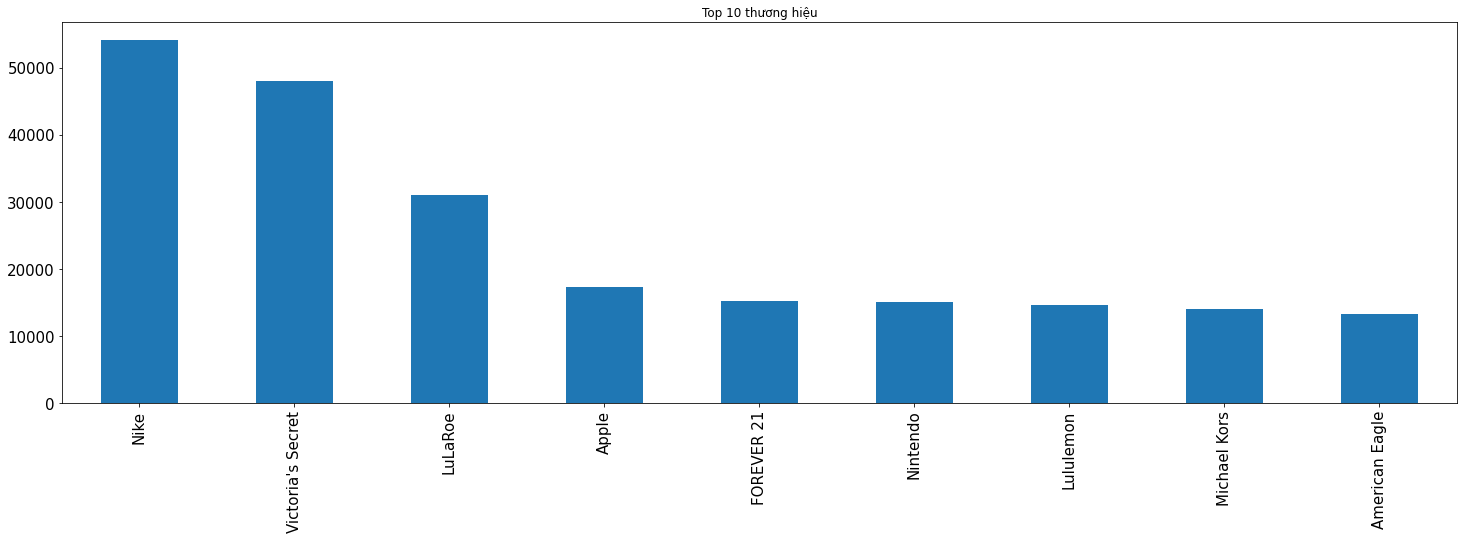

In [21]:
print("Số lượng tên thương hiệu: ",len(list(train_data['brand_name'].unique())))
train_data['brand_name'].value_counts()[1:10].plot(kind='bar', figsize=(25,7), title="Top 10 thương hiệu", fontsize=15)

In [22]:
train_data['brand_name'].isnull().sum(axis=0)

632682

In [23]:
percent_null = train_data.isnull().sum() * 100 / len(train_data)
missing_value = pd.DataFrame({'Phần trăm giá trị null: ': percent_null})
print(missing_value)

                   Phần trăm giá trị null: 
train_id                           0.000000
name                               0.000000
item_condition_id                  0.000000
category_name                      0.426769
brand_name                        42.675687
price                              0.000000
shipping                           0.000000
item_description                   0.000270
log_price                          0.000000


**Nhận xét**:
- Giá trị null trong cột brand_name rất nhiều, chiếm tới ~43 % giá trị trong cột. Ta sẽ cố gắng xử lý dữ liệu bị thiếu ở mục dưới
- Các thương hiệu có nhiều sản phẩm trong tập dữ liệu nhất là: Nike, Victoria's Secret, Lularoe, Apple, FOREVER 21.

### 2.3.8 Phân tích cột category_name
Trong phần convert dữ liệu thì ta chia cột thành 3 cột mới subcat_1, subcat_2, và subcat_3. 

In [24]:
def split_category_name(category_name):
    try:
        sub1, sub2, sub3 = category_name.split('/')
        return sub1, sub2, sub3
    except:
        return "none", "none", "none"

In [25]:
train_data['subcat_1'], train_data['subcat_2'], train_data['subcat_3'] = zip(*train_data['category_name'].apply(lambda text: split_category_name(text)))
train_data.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log_price,subcat_1,subcat_2,subcat_3
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,2.397895,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,3.970292,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,2.397895,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,3.583519,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,3.806662,Women,Jewelry,Necklaces


In [26]:
#số lượng gía trị cột subcat_1
counts = train_data['subcat_1'].value_counts()
print("Women: ", round(counts['Women'] / total_rows * 100, 3), '%')
print("Beauty: ", round(counts['Beauty'] / total_rows * 100, 3), '%')
print("Kids: ", round(counts['Kids'] / total_rows * 100, 3), '%')
print("Electronics: ", round(counts['Electronics'] / total_rows * 100, 3), '%')
print("Men: ", round(counts['Men'] / total_rows * 100, 3), '%')
print("Home: ", round(counts['Home'] / total_rows * 100, 3), '%')
print("Vintage & Collectibles: ", round(counts['Vintage & Collectibles'] / total_rows*100, 3), '%')
print("Other: ", round(counts['Other'] / total_rows * 100, 3), '%')
print("Handmade: ", round(counts['Handmade'] / total_rows * 100, 3), '%')
print("Sports & Outdoors: ", round(counts['Sports & Outdoors'] / total_rows * 100, 3), '%')
print("No Label: ", round(counts['none'] / total_rows * 100, 3),'%')

Women:  44.814 %
Beauty:  14.018 %
Kids:  11.581 %
Electronics:  8.069 %
Men:  6.298 %
Home:  4.578 %
Vintage & Collectibles:  3.139 %
Other:  3.059 %
Handmade:  2.08 %
Sports & Outdoors:  1.641 %
No Label:  0.723 %


**Nhận xét**: Category Women chiếm tỉ lệ cao nhất ~45%, Sports&Outdoors chiếm tỉ lệ thấp nhất ~0.7% 

<AxesSubplot:title={'center':'subcat_1'}>

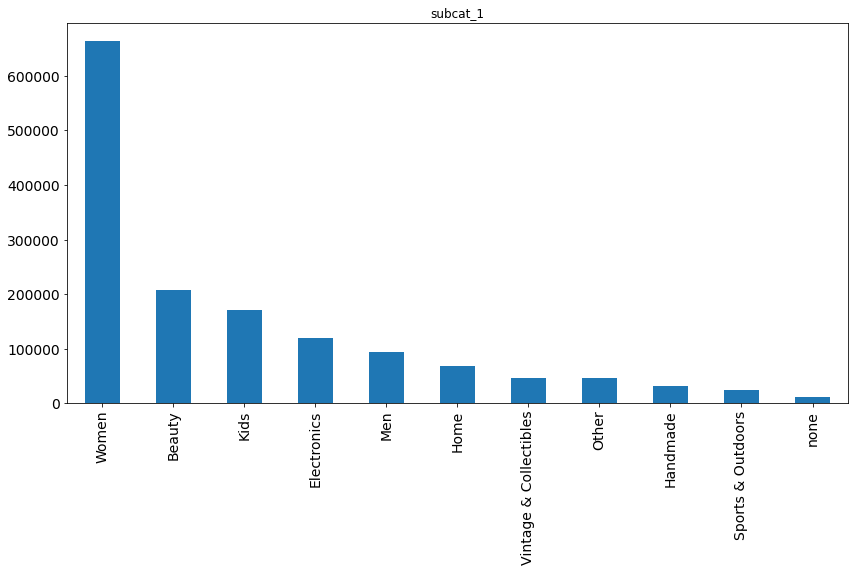

In [27]:
#biểu đồ cột
train_data['subcat_1'].value_counts().plot(kind='bar', figsize=(14,7), title="subcat_1", fontsize=14)

<AxesSubplot:title={'center':'subcat_2'}>

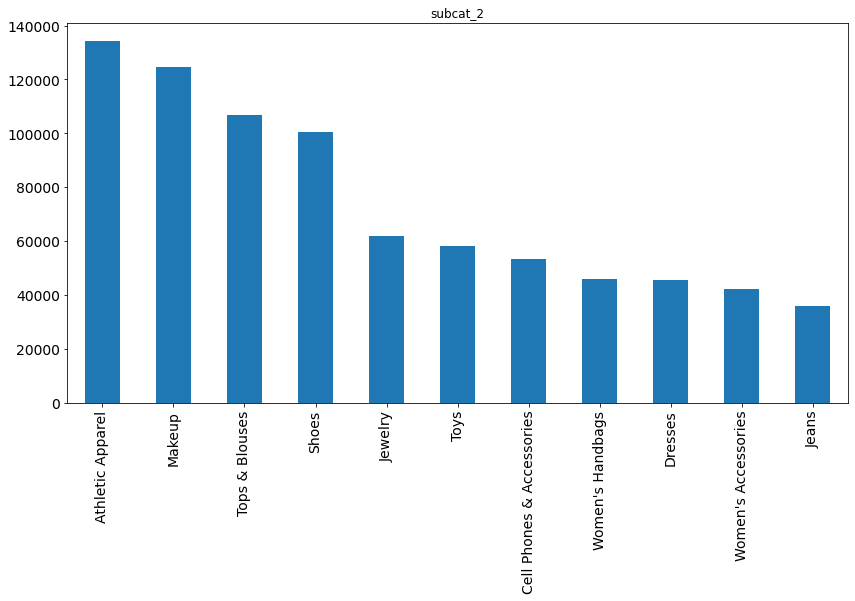

In [28]:
train_data['subcat_2'].value_counts()[:11].plot(kind='bar', figsize=(14,7), title="subcat_2", fontsize=14)

<AxesSubplot:title={'center':'subcat_3'}>

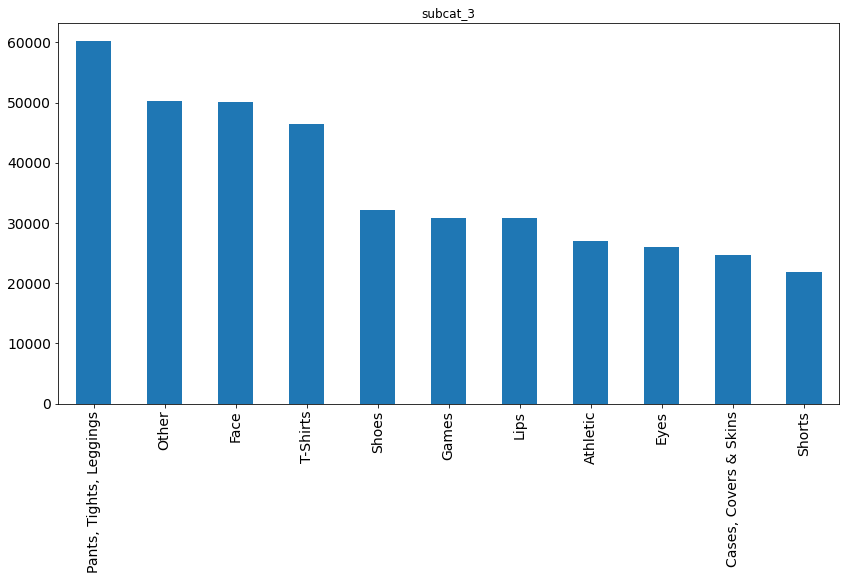

In [29]:
train_data['subcat_3'].value_counts()[:11].plot(kind='bar', figsize=(14,7), title="subcat_3", fontsize=14)

**Nhận xét**: Các sản phẩm tập trung vào:
- Sản phẩm dành cho phụ nữ (Women): Makeup, Shoes, Dress, Women's Handsbags, Women's Accessories, Athletic Apparel, Lips, Skins, 
- Sản phẩm dành cho trẻ em (Kid): Toys, Games,  
- Sản phẩm dành cho nam giới: Electric, Jeans, ...

## 2.4 Convert và clean dữ liệu

### 2.4.1 Xóa các sản phẩm có giá < 5 hoặc > 2000 USD

In [30]:
train_data = train_data[train_data['price']>=5]   
train_data = train_data[train_data['price']<=2000]   
train_data.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log_price,subcat_1,subcat_2,subcat_3
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,2.397895,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,3.970292,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,2.397895,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,3.583519,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,3.806662,Women,Jewelry,Necklaces


### 2.4.2 Xử lý các giá trị null

In [31]:
def fill_missing_values(train_data):
    train_data.category_name.fillna(value="missing", inplace=True)
    train_data.brand_name.fillna(value="missing", inplace=True)
    train_data.item_description.fillna(value="missing", inplace=True)
    return train_data

Giá trị null ở ba cột trên sẽ được thay thế bằng "missing"

### 2.4.3 Xử lý dữ liệu cột category_name

**Nhận xét**: Cột category_name có 3 mục được phân biệt bằng "/". Ta sẽ chia cột thành ba cột mới giúp huấn luyện mô hình chính xác hơn  

In [32]:
def split_category_name(category_name):
    try:
        sub1, sub2, sub3 = category_name.split('/')
        return sub1, sub2, sub3
    except:
        return "none", "none", "none"

### 2.4.4 Điền những giá trị vào cột brand_name

**Nhận xét**: Nhiều sản phẩm trong cột name và item_description có chứa brand_name của chính nó. Do đó có thể tìm brand_name để thay thế giá trị null 

In [33]:
def concat_categories(x):
  return set(x.values)

#hàm dự đoán tên thương hiệu bị mất (dựa trên cột name - có thể có chứa tên thương hiệu)
def guess_brand_name(data_df):
    existing_brand_name = data_df[data_df['brand_name'] != 'missing']['brand_name'].unique()  #giá trị cột brand_name đã tồn tại 
    brand_names_categories = dict(data_df[data_df['brand_name'] != 'missing'][['brand_name', 'category_name']].astype('str').groupby('brand_name').agg(concat_categories).reset_index().values.tolist())
    filled_brand_name = []
    count = 0
    for row in tqdm(data_df[['brand_name', 'name', 'category_name']].values):
        is_find = False
        if row[0] == 'missing':      #neu chua co ten
            for brand in existing_brand_name:
                if brand in row[1] and row[2] in brand_names_categories[brand]:
                    count += 1
                    if count <= 15:
                        print("Giá trị được điền: ", brand)
                    filled_brand_name.append(brand)
                    is_find = True
                    break
            if not is_find:
                filled_brand_name.append('missing')
        else:
            filled_brand_name.append(row[0])
    print("Tổng brand_name được điền: ", count)
    data_df['brand_name'] = filled_brand_name
    return data_df

### 2.4.5 Xử lý dữ liệu cột name và item_description

In [34]:
# I'm -> I am 
def expand_words(text):
    text1 = str(text)
    text1 = re.sub(r"n\'t", " not", text1)
    text1 = re.sub(r"\'re", " are", text1)
    text1 = re.sub(r"\'s", " is", text1)
    text1 = re.sub(r"\'d", " would", text1)
    text1 = re.sub(r"\'ll", " will", text1)
    text1 = re.sub(r"\'t", " not", text1)
    text1 = re.sub(r"\'ve", " have", text1)
    text1 = re.sub(r"\'m", " am", text1)
    return text1

def stem_sentence(sentence):
    ps = PorterStemmer()
    words = word_tokenize(sentence)
    root = []
    for w in words: 
        root.append(ps.stem(w))
    return " ".join(root)

#loai bo 'no', 'nor', 'not', ...
def preprocess_text(text_data):
    stop_words = [
                'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
                'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
                "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
                'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
                'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
                 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
                'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
                'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
                'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
                'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
                's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
                've', 'y'
  ]
    
    text_expand = expand_words(text_data)     #I'm -> I am 
    text_expand = text_expand.replace('\\r', ' ')     #'\r' -> ' '
    text_expand = text_expand.replace('\\n', ' ')
    text_expand = text_expand.replace('\\', ' ')
    text_expand = re.sub('[^A-Za-z0-9]+', ' ', text_expand) #loai bo ^A-Za-z0-9

    text_expand = ' '.join(e for e in text_expand.split() if e.lower() not in stop_words)
    processed_text = stem_sentence(text_expand.lower().strip())
    
    return processed_text

### 2.4.6 Tiền xử lý dữ liệu các cột

In [35]:
def preprocess_all(train_data,test_data):
    train_data = fill_missing_values(train_data)
    test_data = fill_missing_values(test_data)
    train_data['name'] = train_data['name'].apply(preprocess_text)
    train_data['item_description'] = train_data['item_description'].apply(preprocess_text)
    train_data['brand_name'] = train_data['brand_name'].apply(lambda text:str(text).lower()) #lower brand name
    train_data = guess_brand_name(train_data)
    train_data['subcat_1'], train_data['subcat_2'], train_data['subcat_3'] = zip(*train_data['category_name'].apply(split_category_name))
    test_data['subcat_1'], test_data['subcat_2'], test_data['subcat_3'] = zip(*test_data['category_name'].apply(split_category_name))

    return train_data,test_data

In [36]:
train_data, test_data = preprocess_all(train_data, test_data)

  0%|          | 0/1446816 [00:00<?, ?it/s]

Giá trị được điền:  mlb
Giá trị được điền:  ring
Giá trị được điền:  m
Giá trị được điền:  pink
Giá trị được điền:  m
Giá trị được điền:  gucci
Giá trị được điền:  m
Giá trị được điền:  m
Giá trị được điền:  pyrex
Giá trị được điền:  opi
Giá trị được điền:  m
Giá trị được điền:  jordan
Giá trị được điền:  colourpop
Giá trị được điền:  dove
Giá trị được điền:  calvin klein
Tổng brand_name được điền:  103580


**Nhận xét**: Cột brand_name đã được thêm các giá trị: mlb (giày), ring (nhẫn), gucci(túi xách), pyrex(đồ dùng nhà bếp), opi(sơn móng tay), jordan(giày), colourpop (đồ trang điểm), dove(đầu gội), calvin klein(đồng hồ) thay thế cho các giá trị null. Brand_name có ảnh hưởng đến dự đoán giá của sản phẩm và khi đó giúp dự đoán chính xác hơn.

In [37]:
test_data.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,subcat_1,subcat_2,subcat_3
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,missing,1,Size 7,Women,Jewelry,Rings
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,missing,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",Other,Office supplies,Shipping Supplies
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...,Vintage & Collectibles,Bags and Purses,Handbag
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,missing,0,-floral kimono -never worn -lightweight and pe...,Women,Sweaters,Cardigan
4,4,Life after Death,3,Other/Books/Religion & Spirituality,missing,1,Rediscovering life after the loss of a loved o...,Other,Books,Religion & Spirituality


In [38]:
#save train_data
# df = pd.DataFrame(train_data)
# df.to_csv("./train_data_after_process2.tsv",sep="\t", index=False)


In [39]:
#load
# train_data = pd.read_csv("./train_data_after_process2.tsv",sep="\t")

In [40]:
train_data_before = pd.read_csv('train.tsv', sep='\t')

In [41]:
counts = (train_data_before['brand_name'] == 'nike').value_counts()
print(counts)

False    1482535
Name: brand_name, dtype: int64


In [42]:
#dữ liệu sau khi được xử lý 
train_data.loc[train_data['brand_name'] == 'nike']

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,log_price,subcat_1,subcat_2,subcat_3
8,8,girl nike pro short,3,Sports & Outdoors/Apparel/Girls,nike,19.0,0,girl size small plu green three short total,2.995732,Sports & Outdoors,Apparel,Girls
89,89,nike boy sneaker,3,Kids/Boys (4+)/Shoes,nike,28.0,0,size 6y high top super light good condit worn ...,3.367296,Kids,Boys (4+),Shoes
116,116,lebron soldier 9s size 7,2,Men/Shoes/Athletic,nike,51.0,0,boy lebron soldier 9s great condit,3.951244,Men,Shoes,Athletic
151,151,nike men dri fit sleeveless shirt tee,3,Men/Tops/T-shirts,nike,14.0,0,men nike dri fit shirt blue item come clean sm...,2.708050,Men,Tops,T-shirts
172,172,toddler nike tenni shoe,3,Kids/Boys 0-24 Mos/Shoes,nike,10.0,0,no descript yet,2.397895,Kids,Boys 0-24 Mos,Shoes
...,...,...,...,...,...,...,...,...,...,...,...,...
1482378,1482378,roch run,2,Kids/Boys 2T-5T/Shoes,nike,22.0,0,smoke grey red roch run nike shoe size 9c shoe...,3.135494,Kids,Boys 2T-5T,Shoes
1482380,1482380,nike pro sz,3,Women/Athletic Apparel/Shorts,nike,10.0,0,nike pro sz good use condit no stain rip hole ...,2.397895,Women,Athletic Apparel,Shorts
1482430,1482430,nike jordan 5c,3,Kids/Girls 2T-5T/Shoes,nike,14.0,0,no descript yet,2.708050,Kids,Girls 2T-5T,Shoes
1482432,1482432,nwt nike casual gym short,1,Women/Athletic Apparel/Shorts,nike,19.0,0,not quit dark purpl stock photo show comfort c...,2.995732,Women,Athletic Apparel,Shorts


***Kết luận***: 
- Có 42,68 % dữ liệu null trong cột brand_name. Nhưng để ý là người bán thường để brand_name trong cột name. Do đó ta hoàn toàn có thể thay thế giá trị null trong brand_name được. 
- Có khoảng 103000 sản phẩm (theo tính toán bên trên) được thay thế giá trị null trong cột brand_name
- Cột price: phân phối bị lệch sang trái. Ta áp dụng log transformation để chuyển về phân phối chuẩn
- Người mua trả phí ship nhiều hơn người bán trả phí ship
- Tình trạng của mặt hàng: có 5 mức độ từ 1 đến 5. 1 tương ứng với mặt hàng còn mới (chiếm ~43%), tiêp đến là mức độ 3 chiếm ~29%

### 2.4.7 Vector hóa dữ liệu

**Mục đích**: đưa dữ liệu từ dạng text về dạng số thực hoặc vector để làm input cho model

**Cách thực hiện**: 
- sử dụng hàm LabelBinarizer biến đổi dữ liệu hạng mục thành các nhãn nhị phân chỉ chứa giá trị 0 hoặc 1. Một "từ điển" cần được xây dựng chứa tất cả giá trị khả dĩ của từng dữ liệu hạng mục. Sau đó, mỗi hạng mục sẽ được mã hóa bằng một vector nhị phân với toàn bộ các phần tử bằng 0 trừ một phần tử bằng 1 tương ứng với vị trí của hạng mục đó trong từ điển.

#### Vector hóa cột item_condition_id

In [49]:
LabelBinarizer_condition = LabelBinarizer(sparse_output=True)
train_condition = LabelBinarizer_condition.fit_transform(train_data['item_condition_id'])
test_condition = LabelBinarizer_condition.transform(test_data['item_condition_id'])
train_condition.shape

(1446816, 5)

Ma trận train_condition có 1446816 hàng và 5 loại item_condition từ 1 đến 5

#### Vector hóa cột shipping

In [47]:
LabelBinarizer_shipping = LabelBinarizer(sparse_output=True)
train_shipping = LabelBinarizer_shipping.fit_transform(train_data['shipping'])
test_shipping = LabelBinarizer_shipping.transform(test_data['shipping'])
train_shipping.shape

(1446816, 1)

Ma trận train_shipping có 1446816 hàng và 1 cột 

#### Vector hóa cột brand_name

In [50]:
LabelBinarizer_brand = LabelBinarizer(sparse_output=True)
train_brand_name= LabelBinarizer_brand.fit_transform(train_data['brand_name'])
test_brand_name = LabelBinarizer_brand.transform(test_data['brand_name'])

train_brand_name.shape

(1446816, 4779)

Ma trận train_brand_name có 1446816 hàng và 4779 cột (brand_name)

#### Vector hóa cột category_name
- Chuyển đổi các nhãn nhiều lớp sang nhãn nhị phân trong cột category_name sau khi được chia thành 3 cột 

In [51]:
LabelBinarizer_subcat1 = LabelBinarizer(sparse_output=True)
train_cat_1 = LabelBinarizer_subcat1.fit_transform(train_data['subcat_1'])
test_cat_1 = LabelBinarizer_subcat1.transform(test_data['subcat_1'])

LabelBinarizer_subcat2 = LabelBinarizer(sparse_output=True)
train_cat_2 = LabelBinarizer_subcat2.fit_transform(train_data['subcat_2'])
test_cat_2 = LabelBinarizer_subcat2.transform(test_data['subcat_2'])

LabelBinarizer_subcat3 = LabelBinarizer(sparse_output=True)
train_cat_3 = LabelBinarizer_subcat3.fit_transform(train_data['subcat_3'])
test_cat_3 = LabelBinarizer_subcat3.transform(test_data['subcat_3'])


#### Vector  hoá cột name 
Hàm CountVectorizer() chuyển đổi tập hợp mô tả về name thành ma trận 

In [53]:
count_vec = CountVectorizer()
train_name = count_vec.fit_transform(train_data['name'].values.astype('U'))
test_name = count_vec.transform(test_data['name'])

print(train_name.shape)

(1446816, 89313)


#### Vector hoá cột item_description 
TF-IDF (Term Frequency-Inverse Document Frequency) là một kĩ thuật dùng để đánh giá tầm quan trọng của một từ trong văn bản. Giá trị cao thể hiện độ quan trọng cao và phụ thuộc vào số lần xuất hiện trong văn bản nhưng bù lại bởi tần xuất của từ đó trong tập dữ liệu. \
TF: là số lần từ xuất hiện trong văn bản
![](https://drive.google.com/uc?export=view&id=1g9IcOL_AwfIvBkM33ZO0xfMQvtrZX1GF)\
Trong đó:
- tf(t, d): tần suất xuất hiện của từ t trong văn bản d
- f(t, d): số lần xuất hiện của từ t trong văn bản d
- max({f(w, d): w ∈ d}): số lần xuất hiện của từ có số lần xuất hiện nhiều nhất trong d

IDF: nghịch đảo tần suất của văn bản, giúp đánh giá tầm quan trọng của một từ. \
![](https://drive.google.com/uc?export=view&id=1SgFPrBhbaiQuchJl8_IGliMzCwSBvwXq)

Trong đó:
- idf(t, D): giá trị idf của t trong D
- |D|: tổng số văn bản trong tập D
- |{d ∈ D : t ∈ d}|: số văn bản trong tập D có chứ từ t

In [54]:
#TF-IDF
tfidf_des = TfidfVectorizer(max_features=50000, ngram_range=(1, 3), stop_words='english')

train_des = tfidf_des.fit_transform(train_data['item_description'].values.astype('U'))
test_des = tfidf_des.transform(test_data['item_description'])

train_des.shape

(1446816, 50000)

### 2.4.8 Mô hình hóa dữ liệu

#### Kết hợp các cột dữ liệu sau khi vector hóa

In [55]:
from scipy.sparse import hstack
import gc

matrix = (train_name, train_des, train_brand_name, train_condition, train_shipping, train_cat_1, train_cat_2, train_cat_3)

X_train = hstack(matrix).tocsr()
print( X_train.shape)


(1446816, 145088)


# **3. Mô tả thuật toán, mô hình được chọn** 

## 3.1 Công thức đánh giá

### Root Mean Squared Logarithmic Error (RMSLE)
Là độ lệch chuẩn của phần dư. RMSE càng nhỏ thì sai số càng bé và mức độ ước lượng cho thấy độ tin cậy của mô hình có thể chính xác nhất 
![](https://drive.google.com/uc?export=view&id=1LXEtdDhDNGr8FaMWZ7nB97_ssnanFHZd)

Trong đó:
- ϵ là giá trị RMSLE 
- n là tổng số quan sát trong tập dữ liệu
- pi là giá dự đoán của sản phẩm i
- ai là giá trị thực của sản phẩm i
- log(x) là logarit cơ số e (Logarit tự nhiên) của x


In [56]:
#Tính rmsle
def calculate_rmsle(y, y_preds):
    assert len(y) == len(y_preds)
    return np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y_preds), 2)))

## 3.2 Mô hình 

In [57]:
def train_model(model, matrix):
    X = hstack(matrix).tocsr()
    X_train, x_test, Y_train, y_test = train_test_split(X, np.log1p(train_data['price']), test_size=0.2)
    model.fit(X_train, Y_train)
    y_pred = model.predict(x_test)
    del X, X_train, x_test, Y_train
    gc.collect()
    
    return y_pred, y_test

### a) Ridge Regression

**Ridge Regression**: 
- phân tích mối quan hệ giữa các biến độc lập và biến phụ thuộc sử dụng phương pháp điều chỉnh mô hình sao cho giảm thiểu các vấn đề Overfitting, tối ưu hay kiểm soát mức độ phức tạp của mô hình để cân đối giữa Biased và Variance qua đó giảm sai số của mô hình. 
- phân tích dữ liệu hồi qui nhiều lần. 
- khi xảy ra đa cộng tuyến thì các ước lượng bình phương nhỏ nhất là không chệch. Một mức độ chệch được thêm vào các ước tính hồi quy và kết quả là hồi quy sườn núi làm giảm các sai số tiêu chuẩn.
- Công thức:

![](https://drive.google.com/uc?export=view&id=1p0aaEySP0rrCg98-O7ECN3T0sYQsH_Oh)

- Trong đó: λ là tham số Regularization, là số luôn dương, là giá trị mà ở đó phương trình tuyến tính sẽ tính toán được để sai số của mô hình được giảm tối đ

In [58]:
model = ridge = Ridge()
Ridge_preds, y_test = train_model(model, matrix=matrix)

print("RMSLE of Ridge model: " + str(calculate_rmsle(np.expm1(y_test), np.expm1(Ridge_preds))))

RMSLE of Ridge model: 0.45595204575180676


### b) LightGBM Regression
Thuật toán sử dụng "histogram-based algorithms" thay thế cho "pre-sort-based algorithms" thường được dùng trong các boosting tool khác để tìm kiếm split point trong quá trình xây dựng tree. Cải tiến này giúp LightGBM tăng tốc độ training, đồng thời làm giảm bộ nhớ cần sử dụng. Điểm tối ưu của lightgbm so với xgboost là ở 2 thuật toán: GOSS (Gradient Based One Side Sampling) và EFB (Exclusive Feature Bundling) giúp tăng tốc đáng kể trong quá trình tính toán.

LightGBM phát triển tree dựa trên leaf-wise lựa chọn nút để phát triển cây dựa trên tối ưu toàn bộ tree thì xgboost dựa trên level (depth)-wise tối ưu trên nhánh đang xét, do đó, với số node nhỏ, các tree xây dựng từ leaf-wise thường out-perform level-wise.

Leaf-wise thường bị overfit sớm trên dữ liệu nhỏ. Do đó, lightgbm sử dụng thêm 1 hyperparameter là maxdepth nhằm cố gắng hạn chế điều này

In [ ]:
# from scipy.stats import uniform
# from scipy.stats import randint as sp_randint
# from sklearn.model_selection import RandomizedSearchCV

# lgb_model = LGBMRegressor(subsample=0.9)

# params = {'learning_rate': uniform(0, 1),
#           'n_estimators': sp_randint(200, 1500),
#           'num_leaves': sp_randint(20, 200),
#           'max_depth': sp_randint(2, 15),
#           'min_child_weight': uniform(0, 2),
#           'colsample_bytree': uniform(0, 1),
#          }
# lgb_random = RandomizedSearchCV(lgb_model, param_distributions=params, n_iter=10, cv=3, random_state=42, scoring='neg_root_mean_squared_error', verbose=10, return_train_score=True)
# #lgb_random = lgb_random.fit(X_train, y_train)
# lgb_preds, y_test = train_model(lgb_random, matrix=matrix)
# print("RMSLE of LGBM model: " + str(calculate_rmsle(np.expm1(y_test), np.expm1(Xlgb_preds))))

### c) XGBoost
Là một thuật toán state-of-the-art nhằm giải quyết bài toán học có giám sát cho độ chính xác khá cao. Bên cạnh việc nhận đầu vào là tabular datasets với mọi kích thước và dạng dữ liệu thì XGBoost có tốc độ huấn luyện nhanh 

Công thức:

![](https://drive.google.com/uc?export=view&id=1qNStycLgpTj0jyYaYQFoCJgHD8Wx74ym)

In [ ]:
# XGBoost_model = XGBRegressor(n_estimators=200, learning_rate = 0.5, max_depth = 20, min_child_weight = 10)
# XGB_preds, y_test = train_model(XGBoost_model, matrix=matrix)

# print("RMSLE of XGBoost model: " + str(calculate_rmsle(np.expm1(y_test), np.expm1(XGB_preds))))

# **4. Thực nghiệm, báo cáo kết quả**

Mô hình được chọn: Ridge Regression 

In [59]:
def predict_prices():
    matrix_train = (train_name, train_des, train_brand_name, train_condition, train_shipping, train_cat_1, train_cat_2, train_cat_3)
    X_train = hstack(matrix_train).tocsr()
    y_train = np.log1p(train_data['price'])

    Ridge_model =  Ridge()
    Ridge_model.fit(X_train, y_train)
    
    matrix_test = (test_name, test_des, test_brand_name, test_condition, test_shipping, test_cat_1, test_cat_2, test_cat_3)
    X_test = hstack(matrix_test).tocsr()
    preds = Ridge_model.predict(X_test)
    preds = np.expm1(preds)
    return preds

In [60]:
submission = pd.read_csv('sample_submission_stg2.csv')
submission
submission.loc[:, 'price'] = predict_prices()
submission

,test_id,price
0,0,10.147086
1,1,14.773155
2,2,41.969944
3,3,16.598580
4,4,7.935037
...,...,...
3460720,3460720,14.290317
3460721,3460721,35.779226
3460722,3460722,13.303833
3460723,3460723,21.871791


In [61]:
submission.to_csv('submission.csv', index=False)

In [62]:
submission.head

<bound method NDFrame.head of          test_id      price
0              0  10.147086
1              1  14.773155
2              2  41.969944
3              3  16.598580
4              4   7.935037
...          ...        ...
3460720  3460720  14.290317
3460721  3460721  35.779226
3460722  3460722  13.303833
3460723  3460723  21.871791
3460724  3460724  28.492882

[3460725 rows x 2 columns]>

# **5. Rank**